In [1]:
from fastai import *
from fastai.vision import *

Content from this notebook has been inspired from the fast.ai [docs](https://docs.fast.ai/vision.data.html) and course-v3 Part 1. In this notebook we'll go through some ways of creating an `ImageDataBunch` object from a variety of dataset formats. `fastai` library uses a style called the Data Block API to simplify this process and provide flexibility

In [4]:
# Path is a pathlib object that you can use to perform a variety of bash style file system operations
path = Path('../../course-v3/nbs/dl1/data/study_group_mat/')
path,path.ls()

(PosixPath('../../course-v3/nbs/dl1/data/study_group_mat'),
 [PosixPath('../../course-v3/nbs/dl1/data/study_group_mat/tiny-imagenet-200.zip'),
  PosixPath('../../course-v3/nbs/dl1/data/study_group_mat/tiny-imagenet-200')])

## Tiny ImageNet

In [3]:
df_labels = pd.read_csv(path/'tiny-imagenet-200'/'words.txt',sep='\t',header=None,index_col=0)
df_labels.head()

,1
0,
n00001740,entity
n00001930,physical entity
n00002137,"abstraction, abstract entity"
n00002452,thing
n00002684,"object, physical object"


In [4]:
tfms = get_transforms()

In [5]:
from glob import glob

In [6]:
trn_paths = glob(str(path/'tiny-imagenet-200/train/*/images/*.*'))
val_paths = (path/'tiny-imagenet-200/val/images').ls()
trn_paths[:2],val_paths[:2]

(['data/study_group_mat/tiny-imagenet-200/train/n07747607/images/n07747607_183.JPEG',
  'data/study_group_mat/tiny-imagenet-200/train/n07747607/images/n07747607_139.JPEG'],
 [PosixPath('data/study_group_mat/tiny-imagenet-200/val/images/val_4660.JPEG'),
  PosixPath('data/study_group_mat/tiny-imagenet-200/val/images/val_3170.JPEG')])

In [26]:
val_df = pd.read_csv(path/'tiny-imagenet-200/val/val_annotations.txt',sep='\t',header=None,index_col=0)
val_df.head()

,1,2,3,4,5
0,,,,,
val_0.JPEG,n03444034,0,32,44,62
val_1.JPEG,n04067472,52,55,57,59
val_2.JPEG,n04070727,4,0,60,55
val_3.JPEG,n02808440,3,3,63,63
val_4.JPEG,n02808440,9,27,63,48


In [37]:
f = str(path/'tiny-imagenet-200/val/images/val_0.JPEG')

In [40]:
df_labels.at[val_df.at[f.replace(val_f,'').replace('/',''),1],1]

'go-kart'

In [54]:
pat = r"(n\d+)/images/.+\.JPEG$"
val_f = str(path/'tiny-imagenet-200/val/images/')
def get_labels(file_path):
    res = re.search(pat,str(file_path))
    if res: return df_labels.at[res.group(1),1].split()[0]
    else: return df_labels.at[val_df.at[str(file_path).replace(val_f,'').replace('/',''),1],1].split()[0]

In [51]:
trn_f = 'data/study_group_mat/tiny-imagenet-200/train/n07747607/images/n07747607_183.JPEG'
res = re.search(pat,str(trn_f))
res.group(1)

'n07747607'

In [57]:
data = (ImageList.from_folder(path/'tiny-imagenet-200',recurse=True)
                .split_by_folder(train='train',valid='val')
                .label_from_func(get_labels)
                .transform(tfms)
                .databunch()
                .normalize(imagenet_stats))

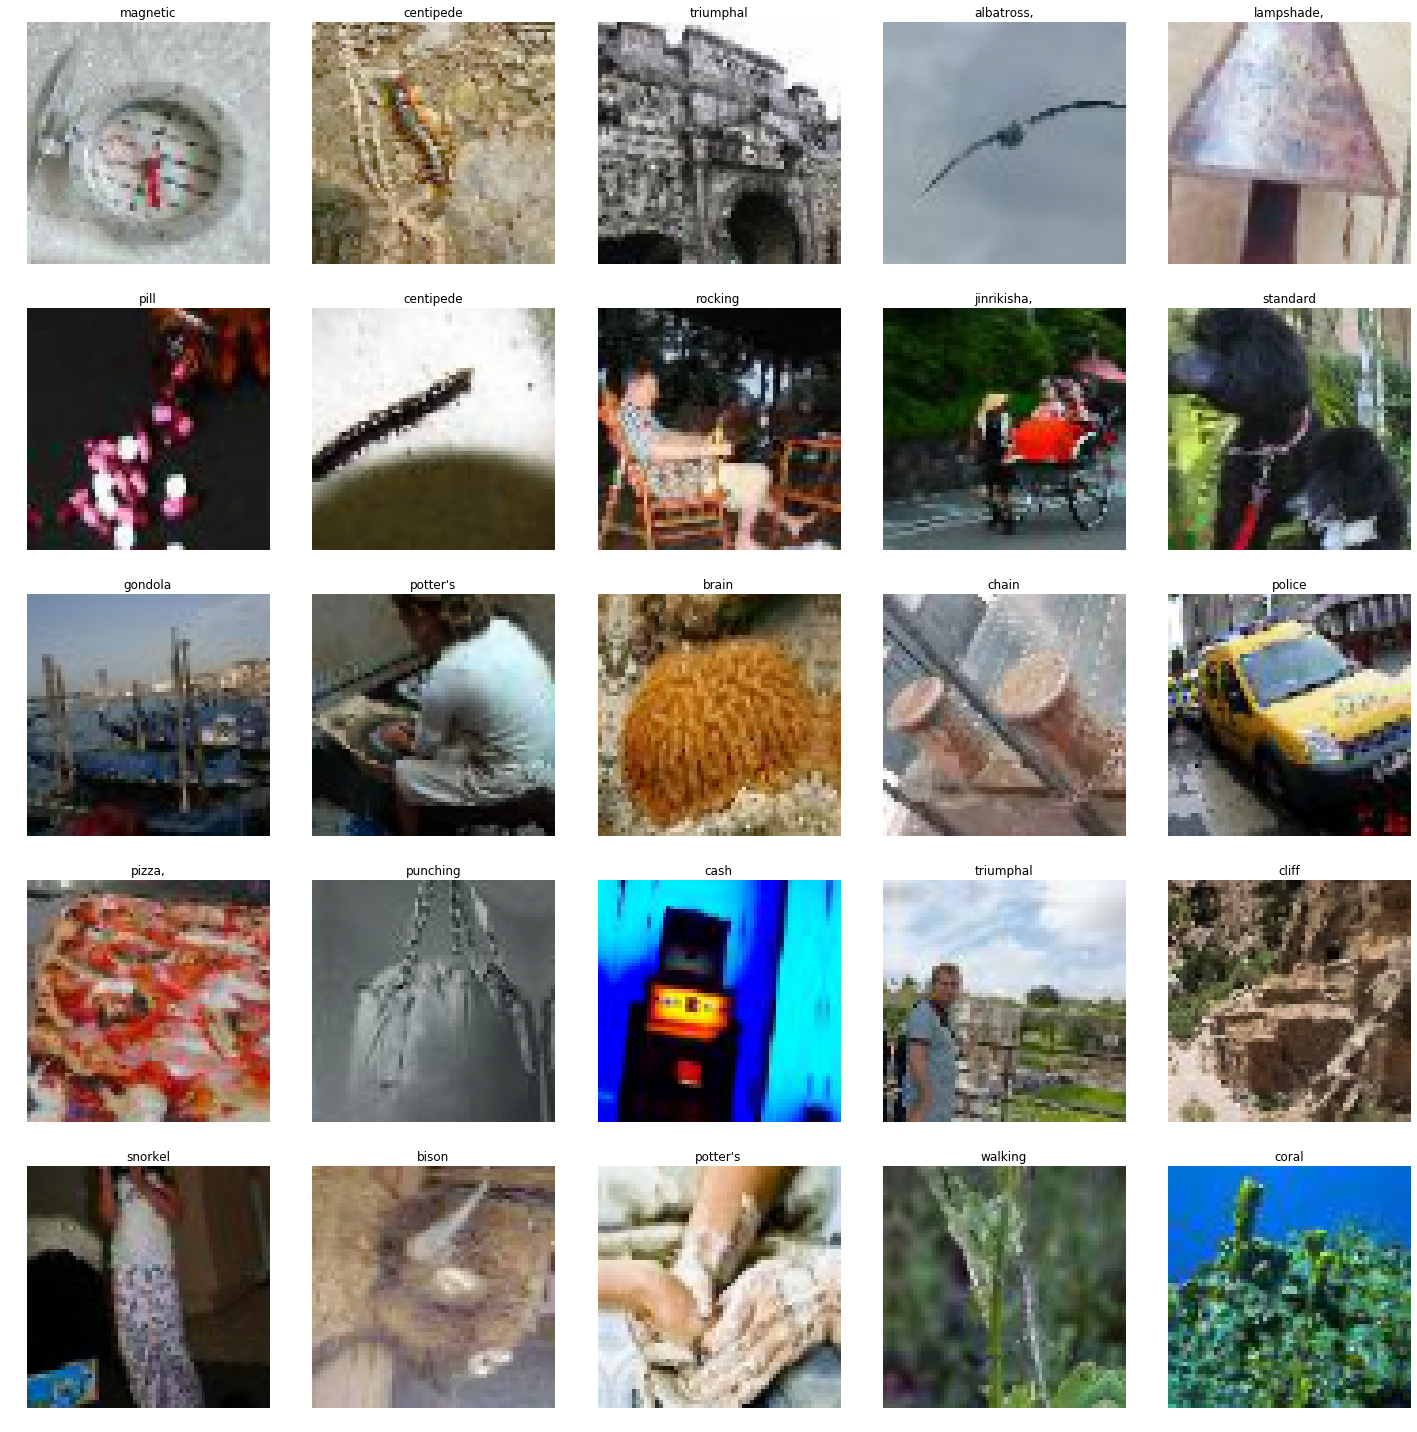

In [58]:
data.show_batch()

## X-Ray Images

In [2]:
path = Path('../../pneumonia/data/')
path,path.ls() 

(PosixPath('../../pneumonia/data'),
 [PosixPath('../../pneumonia/data/stage_1_test_images.zip'),
  PosixPath('../../pneumonia/data/stage_1_test_images'),
  PosixPath('../../pneumonia/data/stage_1_train_images'),
  PosixPath('../../pneumonia/data/stage_1_sample_submission.csv'),
  PosixPath('../../pneumonia/data/stage_1_train_images.zip'),
  PosixPath('../../pneumonia/data/stage_1_detailed_class_info.csv'),
  PosixPath('../../pneumonia/data/GCP%20Credits%20Request%20Link%20-%20RSNA.txt'),
  PosixPath('../../pneumonia/data/tmp'),
  PosixPath('../../pneumonia/data/models'),
  PosixPath('../../pneumonia/data/stage_1_train_labels.csv.zip'),
  PosixPath('../../pneumonia/data/stage_1_train_labels.csv'),
  PosixPath('../../pneumonia/data/stage_1_detailed_class_info.csv.zip')])

In [11]:
TRAIN_IMG = path/'stage_1_train_images'
TRAIN_LABEL = path/'stage_1_train_labels.csv'

In [6]:
import pydicom
from matplotlib import cm
from matplotlib import pyplot as plt
#import cv2

In [56]:
df = pd.read_csv(TRAIN_LABEL)
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
def show_dcm_info(file):
    print("Filename.........:", file_path)
    print("Storage type.....:", file.SOPClassUID)
    print()

    pat_name = file.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", file.PatientID)
    print("Patient's Age.......:", file.PatientAge)
    print("Patient's Sex.......:", file.PatientSex)
    print("Modality............:", file.Modality)
    print("Body Part Examined..:", file.BodyPartExamined)
    print("View Position.......:", file.ViewPosition)
    
    if 'PixelData' in file:
        rows = int(file.Rows)
        cols = int(file.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(file.PixelData)))
        if 'PixelSpacing' in file:
            print("Pixel spacing....:", file.PixelSpacing)

In [14]:
def show_img(file, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(file.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: ../../pneumonia/data/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id..........: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Patient's Age.......: 51
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


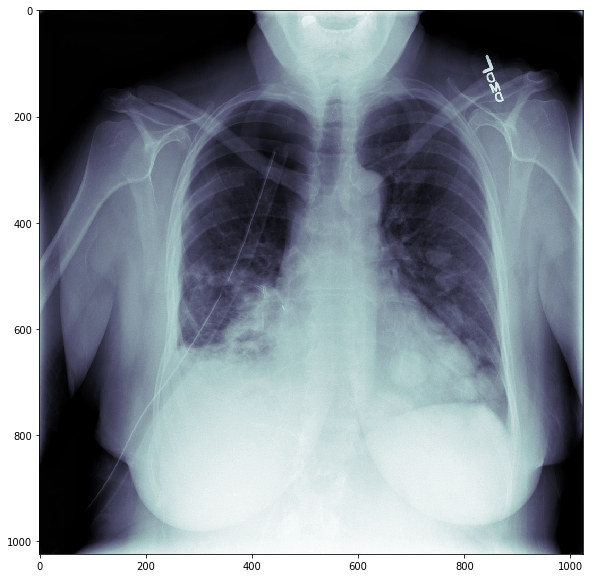

In [18]:
file_path = str(TRAIN_IMG/str(df.iloc[0]['patientId']+'.dcm'))
file = pydicom.dcmread(file_path)
show_dcm_info(file)
show_img(file)

In [25]:
tfms = get_transforms()

In [37]:
data = (ImageList.from_df(df,TRAIN_IMG,cols='patientId',suffix='.dcm')
                 .random_split_by_pct()
                 .label_from_df('Target')
                 .transform(tfms)
                 .databunch())

OSError: cannot identify image file '../../pneumonia/data/stage_1_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm'

In [32]:
open_image??

In [52]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        #custom open
        dicom_arr = pydicom.dcmread(file_path).pixel_array
        x = PIL.Image.fromarray(dicom_arr).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

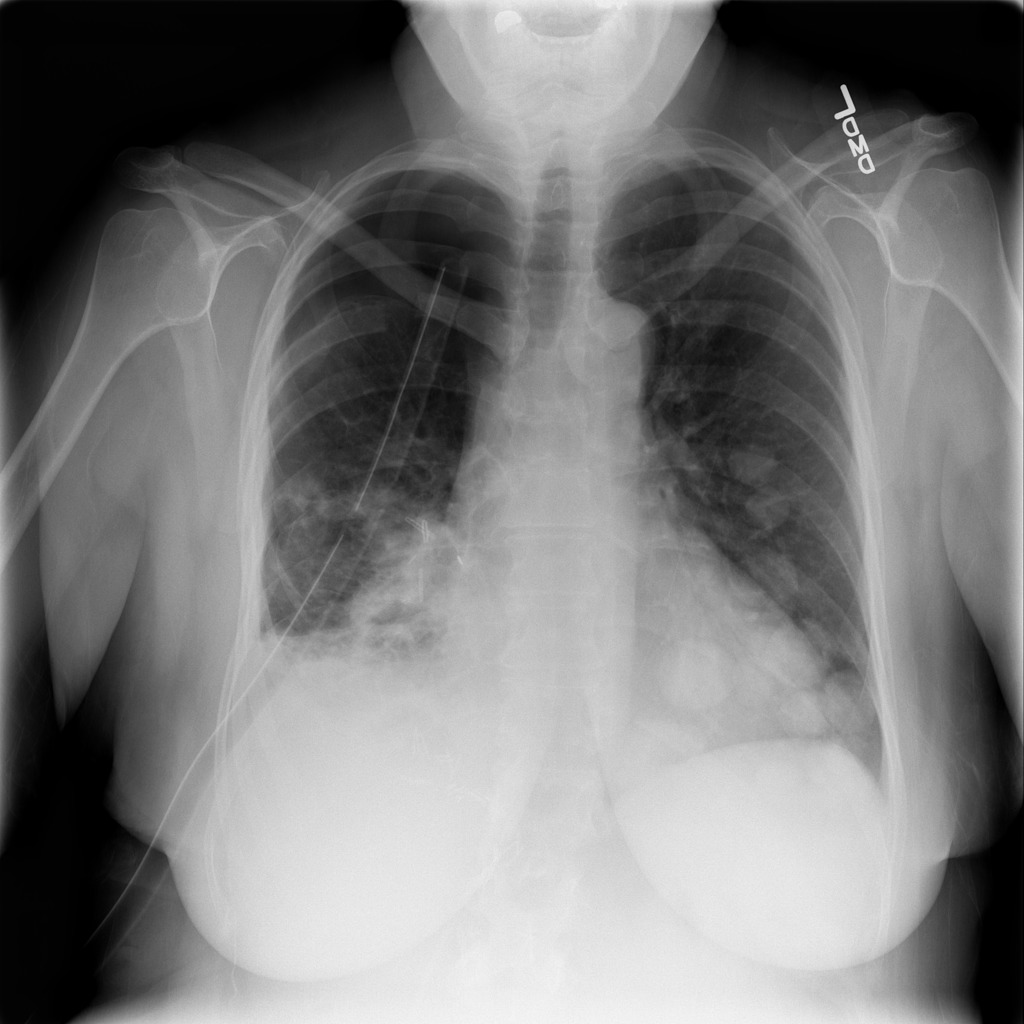

In [36]:
open_image(str(TRAIN_IMG/str(df.iloc[0]['patientId']+'.dcm')))

In [54]:
class DicomItemList(ImageList):
    def open(self, fn): return open_image(fn)

In [59]:
data = (DicomItemList.from_df(df,TRAIN_IMG,cols='patientId',suffix='.dcm')
                 .random_split_by_pct()
                 .label_from_df('Target')
                 .transform(tfms)
                 .databunch(bs=6))

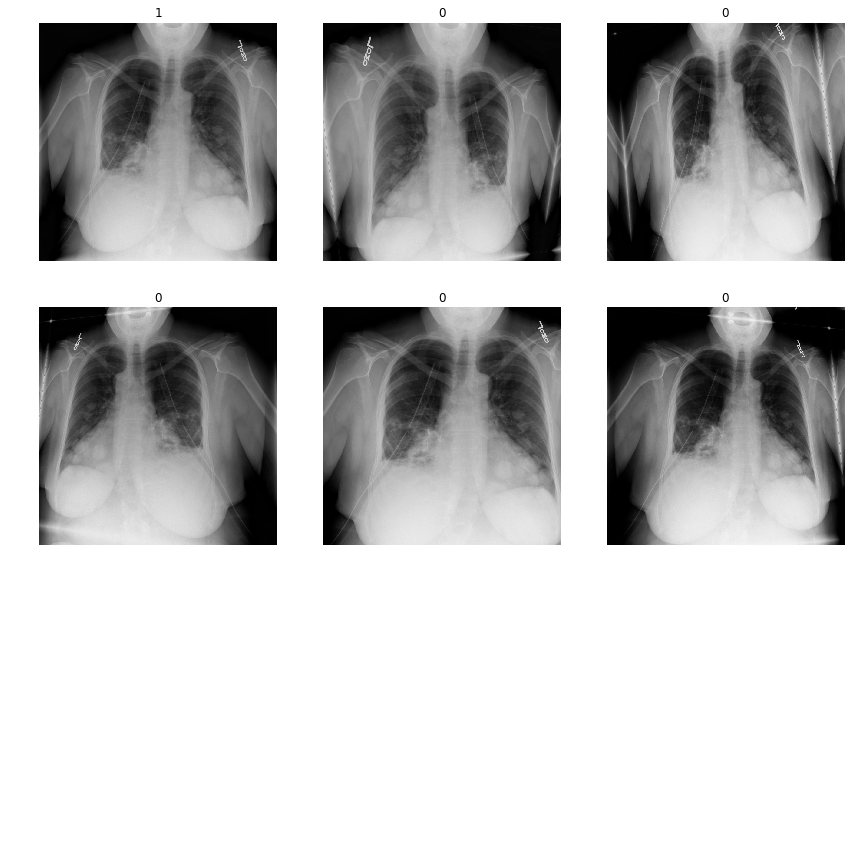

In [60]:
data.show_batch()

## Ultrasound Image Segmentation

In [44]:
path = Path('../../nerve_seg/')
TRAIN_IMG = path/'train'
TRAIN_MASK = path/'train_masks.csv'

In [46]:
TRAIN_IMG.ls()[:4]

[PosixPath('../../nerve_seg/train/16_53.tif'),
 PosixPath('../../nerve_seg/train/44_46.tif'),
 PosixPath('../../nerve_seg/train/5_65_mask.tif'),
 PosixPath('../../nerve_seg/train/9_118.tif')]

In [45]:
df = pd.read_csv(TRAIN_MASK)
df.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [48]:
from fastai import *
from fastai.vision import *

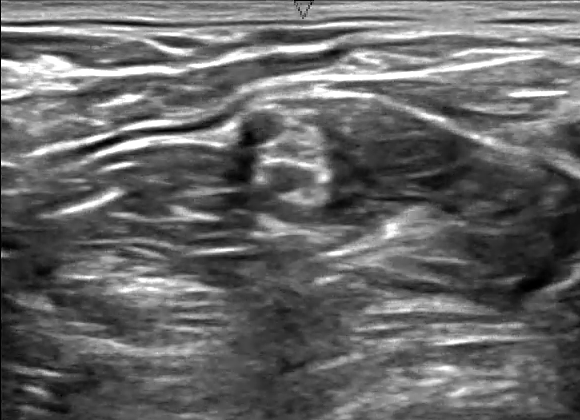

In [49]:
open_image(TRAIN_IMG/'16_53.tif')

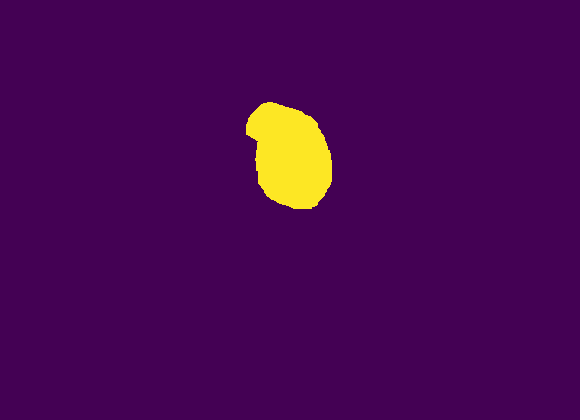

In [51]:
open_mask(TRAIN_IMG/'16_53_mask.tif')